In [1]:
import numpy as np
import pandas as pd

import multiprocessing as multi

from sklearn.mixture import BayesianGaussianMixture

import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
sns.set()

%config InlineBackend.figure_formats = {'png', 'retina'}

np.random.seed(2019)

In [2]:
#loading data
df=pd.read_csv('GaussianMixtureData20130501.txt',header=None,sep='\s+')
df.columns = ['x','y']
df.head()

,x,y
0,-15.589178,-7.633465
1,32.443784,20.345584
2,14.798519,8.051043
3,49.154462,82.325998
4,-38.647685,-8.540052


(-150, 150)

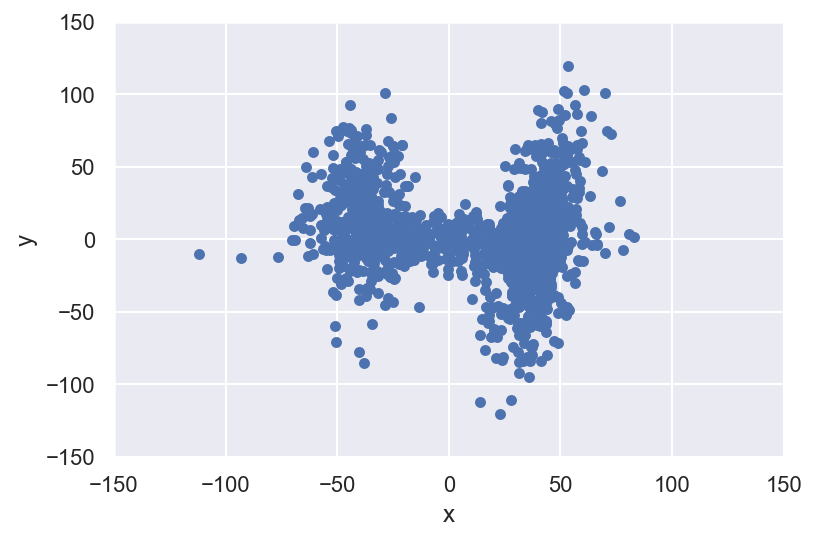

In [3]:
df.plot.scatter(x='x',y='y',c='C0')
plt.xlim([-150,150])
plt.ylim([-150,150])

In [4]:
from scipy.special import digamma, gammaln, multigammaln, xlogy
from numpy.linalg import inv, det
from tqdm import trange

In [5]:
# init
K=10
N,D=df.shape
a_0=D+1
beta_0=D+1
nu_0=D+1
mu_0=1/N*df.values.sum(axis=0)

tmp=(df.values-mu_0)
V_0=inv(nu_0*1/N*np.dot(tmp.T,tmp))

# eps=np.random.multivariate_normal(mu_0, 1/beta_0*inv(nu_0*V_0)) #直接は使わない

In [6]:
# calc roh
def update_rho(X ,a, beta, nu, mu, V, D):
    rho_list=[] #store rhos by k
    for a_k, beta_k, nu_k, mu_k, V_k in zip(a,beta,nu,mu,V):
        d=np.array([range(1,D+1)]) 
        tmp=(X - mu_k)
        quadratic_term=nu_k*np.diag(np.dot(np.dot(tmp,V_k),tmp.T)) #last term
        #n-dimention vector
        rho=np.exp(digamma(a_k)+1/2*(digamma((nu_k+1-d)/2).sum() + np.log(det(V_k)) - D/beta_k - quadratic_term))

        rho_list.append(rho)

    return np.array(rho_list) # (K,N)

def update_other_params(X,rho):
    #calc r (this is n-dimentional vector)
    r=rho/rho.sum(axis=0) #(K,N)

    #eta
    eta=r.sum(axis=1) #(K,)
    
    # update params
    a=a_0 + eta #(K,)
    beta=beta_0 + eta
    nu=nu_0+eta
    mu=(beta_0*mu_0+np.dot(r,X))/beta.reshape(-1,1) #(K,2)
    
    # update V
    V_list=[]
    for mu_k, r_k in zip(mu, r):
        tmp=(mu_k - mu_0).reshape(-1,1)
        second_term=beta_0*np.dot(tmp,tmp.T) # (D,D)
        assert second_term.shape==(2,2)
        x_k_mu_k=np.tile((X-mu_k).reshape(N,2,1),(1,1,2)) #(N,D,D)        
        third_term=(r_k.reshape(-1,1,1)*(x_k_mu_k*x_k_mu_k.transpose(0,2,1))).sum(axis=0) # (D,D)
        assert third_term.shape==(2,2)
        

        V_k=inv(inv(V_0) + second_term + third_term) #(D,D)
        V_list.append(V_k)
    V=np.array(V_list) #(K,D,D)
    
    return a,beta,nu,mu,V,r,eta

def fit(X,n_components=10, n_iter=500):
    # first insertion
    a=np.full(n_components,a_0) #(K, N)
    beta=np.full(n_components,beta_0)
    nu=np.full(n_components,nu_0)
    mu=np.random.multivariate_normal(mu_0,1/beta_0*inv(nu_0*V_0),size=n_components) #(K,D)
    V=np.tile(V_0,(n_components,1,1)) #(K, V_k_0, V_k_1)
    
    for _ in trange(n_iter):
        rho=update_rho(X,a, beta, nu, mu, V, X.shape[1])
        a, beta, nu, mu, V,r,eta=update_other_params(X,rho)

    return rho,a, beta, nu, mu, V,r,eta
    

1. 混合数選択基準

In [7]:
def select_n_components(X:np.array)->int:
    cost=float('inf')
    ret=None
    history=[]
    for n_comp in range(1,11):
        rho,a, beta, nu, mu, V,r,eta=fit(X, n_components=n_comp, n_iter=500)
        
        #first term
        term_1=gammaln(n_comp*a_0+X.shape[0])-gammaln(n_comp*a_0)
        #second term
        term_2=xlogy(r,r).sum()
        #third term
        term_3=(gammaln(a_0)+multigammaln(nu_0/2,X.shape[1])-gammaln(a)-multigammaln(nu/2,X.shape[1])).sum()
        #fourth
        term_4=(1/2*((nu_0*np.log(det(V_0))-nu*np.log(det(V)))+X.shape[1]*np.log(beta/beta_0))).sum()
        cost_tmp=term_1+term_2+term_3+term_4
        history.append(cost_tmp)
        if cost_tmp<cost:
            cost=cost_tmp
            ret=n_comp
    return ret,history
        

In [8]:
best_n_comp, cost_history=select_n_components(df.values)

100%|██████████| 500/500 [00:41<00:00, 11.96it/s]


In [9]:
best_n_comp

3

In [10]:
cost_history

[11453.431326031015,
 11021.39216220153,
 10897.180865463717,
 10910.562335261875,
 10923.165727611038,
 10935.156948347247,
 10946.643921768034,
 10957.702531985313,
 10968.38906571686,
 10978.746940853533]

2. 最適混合数での事後平均解

In [11]:
rho,a, beta, nu, mu, V, r, eta=fit(df.values, n_components=best_n_comp,n_iter=1000)

100%|██████████| 1000/1000 [00:26<00:00, 37.85it/s]


In [12]:
print('混合率\n',a/a.sum())
print()
print('平均\n',mu)
print()
print('共分散\n',inv(nu.reshape(-1,1,1)*V))

混合率
 [0.26724881 0.26842827 0.46432292]

平均
 [[-38.39188083  17.12650548]
 [  1.10079448  -0.65552791]
 [ 39.79671903  -0.13783562]]

共分散
 [[[ 149.75452082  -26.3415799 ]
  [ -26.3415799   936.12614125]]

 [[ 969.01693593   14.34576424]
  [  14.34576424  107.56626137]]

 [[ 113.72048052  192.08286852]
  [ 192.08286852 1562.80199265]]]


3. 混合正規分布の図示

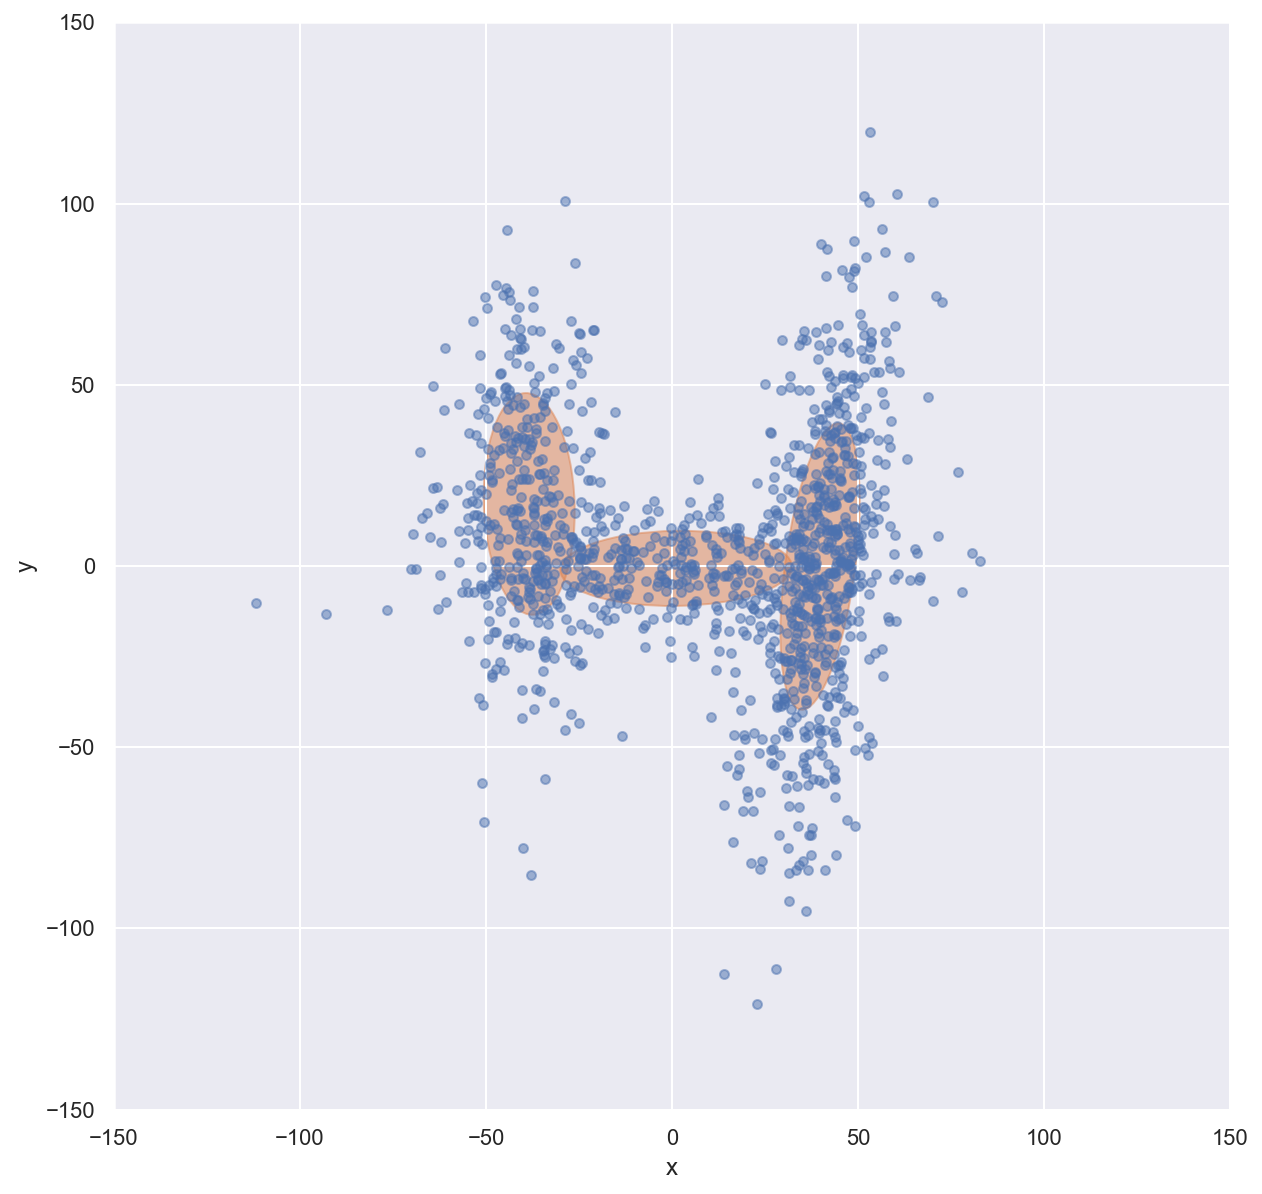

In [13]:
ax=df.plot.scatter(x="x",y='y',figsize=(10,10),zorder=1,alpha=0.5,c='C0')
ax.set_xlim([-150,150])
ax.set_ylim([-150,150])

for V_k,mu_k in zip(inv(nu.reshape(-1,1,1)*V),mu):
    w, v = np.linalg.eigh(V_k)    
    angle = np.degrees(np.arctan2(v[0, 1], v[0, 0]))
    height, width = 2 * np.sqrt(w)

    ell = mpl.patches.Ellipse(mu_k, height, width, angle, color='C1',alpha=0.5,zorder=0)
    ax.add_artist(ell)

misc

In [4]:
from scipy.special import digamma, gammaln, multigammaln
from numpy.linalg import inv, det

In [13]:
# init
K=10
N,D=df.shape
a_0=D+1
beta_0=D+1
nu_0=D+1
mu_0=1/N*df.values.sum(axis=0)

tmp=(df.values-mu)
V_0=inv(nu*1/N*np.dot(tmp.T,tmp))

eps=np.random.multivariate_normal(mu, 1/beta*inv(nu*V))

In [14]:
# first insertion
a=np.full(K,a_0)
beta=np.full(K,beta_0)
nu=np.full(K,nu_0)
mu=eps.copy()

V=V_0.copy()

In [15]:
# iter until convergence

# calc roh
# shape rule (n,k)
d=np.array([range(1,D+1)]) 
tmp=(df.values - mu)
quadratic_term=nu*np.diag(np.dot(np.dot(tmp,V),tmp.T)) #last term
#n-dimention vector
rho=np.exp(digamma(a)+1/2*(digamma((nu+1-d)/2).sum() + np.log(det(V)) - D/beta - quadratic_term))

#calc r (this is n-dimentional vector)
r=rho/rho.sum()

#eta
eta=r.sum()



ValueError: operands could not be broadcast together with shapes (10,) (1300,) 

In [12]:
        # (K,2,2)
        second_term=beta_0*np.array([np.dot((mu_i - mu_0).reshape(-1,1),(mu_i - mu_0).reshape(1,-1)) for mu_i in mu])
        # ()
        third_term
        #(K,2,2)
        V=


1.0

In [107]:
np.log(det(V))

-16.407567883886195

In [103]:
roh

3.691734630897648e-07

In [90]:
tmp=(df.values-mu)

In [96]:
np.dot(tmp.T,tmp)

array([[1833089.52483306, -168203.60700558],
       [-168203.60700558, 1383719.76291301]])

In [60]:
bgm=BayesianGaussianMixture(n_components=10,covariance_type='full',max_iter=1000)

In [61]:
bgm.fit(df.values)

BayesianGaussianMixture(covariance_prior=None, covariance_type='full',
                        degrees_of_freedom_prior=None, init_params='kmeans',
                        max_iter=1000, mean_precision_prior=None,
                        mean_prior=None, n_components=10, n_init=1,
                        random_state=None, reg_covar=1e-06, tol=0.001,
                        verbose=0, verbose_interval=10, warm_start=False,
                        weight_concentration_prior=None,
                        weight_concentration_prior_type='dirichlet_process')

In [62]:
bgm.weight_concentration_prior_

0.1

In [63]:
bgm.n_components

10

In [64]:
bgm.means_

array([[-38.93071864,  17.46033074],
       [  8.565431  ,   4.08349196],
       [  1.13985183,  -0.66618718],
       [  8.56458537,   4.08764446],
       [  8.56447689,   4.08817691],
       [  8.56436868,   4.08870799],
       [ 39.98349874,  -0.1284579 ],
       [  8.5138306 ,   4.33706673],
       [  8.51382878,   4.33707569],
       [  8.51382878,   4.33707569]])

In [69]:
bgm.degrees_of_freedom_

array([342.83969924,   2.0683697 , 361.95179792,   2.06739666,
         2.06725073,   2.06710517, 600.9383782 ,   2.00000239,
         2.        ,   2.        ])

In [70]:
bgm.degrees_of_freedom_prior_

2

In [72]:
bgm.lower_bound_

-10083.26478491975

In [73]:
bgm.precisions_cholesky_

array([[[ 0.09134318,  0.00477293],
        [ 0.        ,  0.03260347]],

       [[ 0.03762306,  0.00395526],
        [ 0.        ,  0.04365883]],

       [[ 0.03210945, -0.00124621],
        [ 0.        ,  0.09983399]],

       [[ 0.03762332,  0.00395591],
        [ 0.        ,  0.04365765]],

       [[ 0.03762337,  0.003956  ],
        [ 0.        ,  0.04365748]],

       [[ 0.03762342,  0.00395609],
        [ 0.        ,  0.0436573 ]],

       [[ 0.09866911, -0.05448601],
        [ 0.        ,  0.0287741 ]],

       [[ 0.03764677,  0.00399837],
        [ 0.        ,  0.04357438]],

       [[ 0.03764677,  0.00399837],
        [ 0.        ,  0.04357438]],

       [[ 0.03764677,  0.00399837],
        [ 0.        ,  0.04357438]]])

In [74]:
bgm.precisions_

array([[[ 0.00836636,  0.00015561],
        [ 0.00015561,  0.00106299]],

       [[ 0.00143114,  0.00017268],
        [ 0.00017268,  0.00190609]],

       [[ 0.00103257, -0.00012441],
        [-0.00012441,  0.00996683]],

       [[ 0.00143116,  0.00017271],
        [ 0.00017271,  0.00190599]],

       [[ 0.00143117,  0.00017271],
        [ 0.00017271,  0.00190598]],

       [[ 0.00143117,  0.00017271],
        [ 0.00017271,  0.00190596]],

       [[ 0.01270432, -0.00156779],
        [-0.00156779,  0.00082795]],

       [[ 0.00143327,  0.00017423],
        [ 0.00017423,  0.00189873]],

       [[ 0.00143327,  0.00017423],
        [ 0.00017423,  0.00189873]],

       [[ 0.00143327,  0.00017423],
        [ 0.00017423,  0.00189873]]])

In [75]:
bgm.weight_concentration_

(array([341.83969924,   1.0683697 , 360.95179792,   1.06739666,
          1.06725073,   1.06710517, 599.9383782 ,   1.00000239,
          1.        ,   1.        ]),
 array([9.59260301e+02, 9.59191931e+02, 5.99240133e+02, 5.99172736e+02,
        5.99105486e+02, 5.99038381e+02, 1.00002387e-01, 1.00000000e-01,
        1.00000000e-01, 1.00000000e-01]))

In [77]:
bgm.covariance_prior_

array([[1411.15436862, -129.48699539],
       [-129.48699539, 1065.21921702]])

In [79]:
bgm.degrees_of_freedom_

array([342.83969924,   2.0683697 , 361.95179792,   2.06739666,
         2.06725073,   2.06710517, 600.9383782 ,   2.00000239,
         2.        ,   2.        ])

In [81]:
bgm.weight_concentration_

(array([341.83969924,   1.0683697 , 360.95179792,   1.06739666,
          1.06725073,   1.06710517, 599.9383782 ,   1.00000239,
          1.        ,   1.        ]),
 array([9.59260301e+02, 9.59191931e+02, 5.99240133e+02, 5.99172736e+02,
        5.99105486e+02, 5.99038381e+02, 1.00002387e-01, 1.00000000e-01,
        1.00000000e-01, 1.00000000e-01]))

In [82]:
bgm.precisions_

array([[[ 0.00836636,  0.00015561],
        [ 0.00015561,  0.00106299]],

       [[ 0.00143114,  0.00017268],
        [ 0.00017268,  0.00190609]],

       [[ 0.00103257, -0.00012441],
        [-0.00012441,  0.00996683]],

       [[ 0.00143116,  0.00017271],
        [ 0.00017271,  0.00190599]],

       [[ 0.00143117,  0.00017271],
        [ 0.00017271,  0.00190598]],

       [[ 0.00143117,  0.00017271],
        [ 0.00017271,  0.00190596]],

       [[ 0.01270432, -0.00156779],
        [-0.00156779,  0.00082795]],

       [[ 0.00143327,  0.00017423],
        [ 0.00017423,  0.00189873]],

       [[ 0.00143327,  0.00017423],
        [ 0.00017423,  0.00189873]],

       [[ 0.00143327,  0.00017423],
        [ 0.00017423,  0.00189873]]])

In [83]:
bgm.precisions_cholesky_

array([[[ 0.09134318,  0.00477293],
        [ 0.        ,  0.03260347]],

       [[ 0.03762306,  0.00395526],
        [ 0.        ,  0.04365883]],

       [[ 0.03210945, -0.00124621],
        [ 0.        ,  0.09983399]],

       [[ 0.03762332,  0.00395591],
        [ 0.        ,  0.04365765]],

       [[ 0.03762337,  0.003956  ],
        [ 0.        ,  0.04365748]],

       [[ 0.03762342,  0.00395609],
        [ 0.        ,  0.0436573 ]],

       [[ 0.09866911, -0.05448601],
        [ 0.        ,  0.0287741 ]],

       [[ 0.03764677,  0.00399837],
        [ 0.        ,  0.04357438]],

       [[ 0.03764677,  0.00399837],
        [ 0.        ,  0.04357438]],

       [[ 0.03764677,  0.00399837],
        [ 0.        ,  0.04357438]]])